In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting style
plt.style.use('default')
sns.set_palette('husl')

In [2]:
# Load and analyze the coding matrix
import pandas as pd
import os

# Check if file exists with correct name
file_path = "coding matrix.csv"  # Fixed filename with space
if not os.path.exists(file_path):
    print(f"File not found: {file_path}. Available files:")
    print([f for f in os.listdir('.') if f.endswith('.csv')])
else:
    # Load the coding matrix exported from NVivo
    df = pd.read_csv(file_path)
    print(f"Successfully loaded {file_path}")
    print(f"Data shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print("\nFirst few rows:")
    print(df.head())

Successfully loaded coding matrix.csv
Data shape: (335, 82)
Columns: ['Unnamed: 0', 'A : Academic Success', 'B : Access to UREs', 'C : COVID-19', 'D : Discipline', 'E : Social Sciences and or Humanities', 'F : STEM', 'G : Experiences and Outcomes of URE', 'H : Academic Success', 'I : Awards', 'J : GPA', 'K : Graduation', 'L : Persistence and Retention', 'M : Publications', 'N : Transfer', 'O : Access to UREs', 'P : Application Experiences', 'Q : Barriers to URE', 'R : Share of URM Students', 'S : General Perceptions and Experiences', 'T : Experiences', 'U : Program Expectations', 'V : Satisfaction', 'W : Graduate School and Career', 'X : Aspirations OR Expectations related to attending Graduate School', 'Y : Career Readiness', 'Z : Earnings', 'AA : Employment', 'AB : Enrollment in a Graduate Program', 'AC : Future or Long-Term Planning', 'AD : Identity Development', 'AE : Individual Identity Development', 'AF : Professional Identity Development', 'AG : Non-Cognitive Skills', 'AH : Comm

In [3]:
# Analysis functions for coding matrix
def analyze_coding_matrix(df):
    """Analyze the coding matrix and generate summaries"""
    
    # Assumes first column is article/source identifier
    article_column = df.columns[0]
    print(f"Article identifier column: {article_column}")
    
    # Get code columns (exclude first column and any we'll create)
    code_columns = df.columns[1:].tolist()
    print(f"Number of codes: {len(code_columns)}")
    
    # Compute: Total number of codes applied per article
    df['Total_Codes_Applied'] = df[code_columns].sum(axis=1)
    
    # For each article, list codes with nonzero counts
    def get_applied_codes(row):
        applied = [col for col in code_columns if row[col] > 0]
        return ', '.join(applied)
    
    df['Codes_Applied'] = df.apply(get_applied_codes, axis=1)
    
    return df, article_column, code_columns

def create_summaries(df, article_column, code_columns):
    """Create and save summary reports"""
    
    # Article summary
    article_summary = df[[article_column, 'Total_Codes_Applied', 'Codes_Applied']].copy()
    article_summary.to_csv('article_summary.csv', index=False)
    print("Article Summary:")
    print(article_summary)
    
    # Code totals across articles
    code_totals = pd.DataFrame({
        'Num_Articles': (df[code_columns] > 0).sum(axis=0),
        'Total_Applications': df[code_columns].sum(axis=0)
    })
    code_totals = code_totals.sort_values('Total_Applications', ascending=False)
    code_totals.to_csv('code_summary.csv')
    print("\nCode Summary:")
    print(code_totals)
    
    return article_summary, code_totals

In [6]:
# Run the analysis
if 'df' in locals():
    # Analyze the coding matrix
    df_analyzed, article_col, code_cols = analyze_coding_matrix(df.copy())
    
    # Create summaries
    article_summary, code_summary = create_summaries(df_analyzed, article_col, code_cols)
    
    print(f"\nAnalysis complete!")
    print(f"- Analyzed {len(df_analyzed)} articles")
    print(f"- Found {len(code_cols)} codes")
    print(f"- Saved article_summary.csv and code_summary.csv")
else:
    print("Please run the data loading cell first!")

Article identifier column: Unnamed: 0
Number of codes: 81
Article Summary:
                                            Unnamed: 0  Total_Codes_Applied  \
0    1 : A 3+8 Model of Undergraduate Research for ...                    9   
1    2 : A Case of Reform~ The Undergraduate Resear...                    7   
2    3 : A case study of a novel summer bridge prog...                    6   
3    4 : A Community Mentoring Model for STEM Under...                    6   
4    5 : A Course-Based Undergraduate Research Expe...                    8   
..                                                 ...                  ...   
330  331 : ~A Place to Be Heard and to Hear~~ the H...                   11   
331  332 : ~Entering Research~~ A Course that Creat...                    8   
332  333 : ~How Do We Do This at a Distance~!~ A De...                   11   
333  334 : ~I Definitely Feel Like a Scientist~~ Ex...                   10   
334  335 : ~I Think I'm the Bridge~~ Exploring Ment...  

In [4]:
# Create comprehensive spreadsheets with metadata
import re
from datetime import datetime

def extract_metadata_from_title(title):
    """Extract metadata from article titles where possible"""
    metadata = {
        'title': title,
        'extracted_year': None,
        'extracted_author': None,
        'extracted_journal': None,
        'title_length': len(title) if pd.notna(title) else 0
    }
    
    if pd.notna(title):
        # Try to extract year (4-digit number)
        year_match = re.search(r'\b(19|20)\d{2}\b', title)
        if year_match:
            metadata['extracted_year'] = int(year_match.group())
        
        # Extract potential author info (text before first colon if pattern suggests author)
        if ':' in title:
            parts = title.split(':')
            if len(parts[0]) < 50:  # Likely author if short
                metadata['extracted_author'] = parts[0].strip()
                metadata['title'] = ':'.join(parts[1:]).strip()
    
    return metadata

def create_comprehensive_spreadsheets(df):
    """Create detailed spreadsheets for analysis"""
    
    # Get article identifier and code columns
    article_col = df.columns[0]
    code_columns = [col for col in df.columns[1:] if not col.startswith('Total_') and col != 'Codes_Applied']
    
    print(f"Processing {len(df)} articles with {len(code_columns)} codes...")
    
    # Extract metadata from titles
    metadata_list = []
    for idx, row in df.iterrows():
        title = row[article_col]
        metadata = extract_metadata_from_title(title)
        metadata['article_id'] = idx + 1
        metadata['original_identifier'] = title
        metadata_list.append(metadata)
    
    metadata_df = pd.DataFrame(metadata_list)
    
    # 1. ARTICLES WITH CODES AND METADATA
    article_analysis = []
    for idx, row in df.iterrows():
        article_data = {
            'Article_ID': idx + 1,
            'Original_Identifier': row[article_col],
            'Title': metadata_list[idx]['title'],
            'Extracted_Year': metadata_list[idx]['extracted_year'],
            'Extracted_Author': metadata_list[idx]['extracted_author'],
            'Title_Length': metadata_list[idx]['title_length'],
            'Total_Codes_Applied': sum(row[code_columns]),
            'Number_of_Codes': sum(1 for col in code_columns if row[col] > 0),
            'Codes_Applied': ', '.join([col for col in code_columns if row[col] > 0]),
            'Code_Frequencies': ', '.join([f"{col}({row[col]})" for col in code_columns if row[col] > 0])
        }
        
        # Add individual code columns
        for code in code_columns:
            article_data[f"Code_{code}"] = row[code]
        
        article_analysis.append(article_data)
    
    articles_df = pd.DataFrame(article_analysis)
    
    # 2. CODES WITH ARTICLE DETAILS
    code_analysis = []
    for code in code_columns:
        articles_with_code = df[df[code] > 0]
        
        code_data = {
            'Code_Name': code,
            'Total_Applications': df[code].sum(),
            'Number_of_Articles': len(articles_with_code),
            'Percentage_of_Articles': round((len(articles_with_code) / len(df)) * 100, 2),
            'Average_Applications_per_Article': round(df[code].mean(), 3),
            'Max_Applications_in_Single_Article': df[code].max(),
            'Articles_with_Code': ' | '.join(articles_with_code[article_col].astype(str)),
            'Article_IDs_with_Code': ', '.join([str(idx+1) for idx in articles_with_code.index])
        }
        
        # Add year analysis if years were extracted
        years = [metadata_list[idx]['extracted_year'] for idx in articles_with_code.index 
                if metadata_list[idx]['extracted_year'] is not None]
        if years:
            code_data['Earliest_Year'] = min(years)
            code_data['Latest_Year'] = max(years)
            code_data['Year_Range'] = f"{min(years)}-{max(years)}"
        else:
            code_data['Earliest_Year'] = None
            code_data['Latest_Year'] = None
            code_data['Year_Range'] = 'No years extracted'
        
        code_analysis.append(code_data)
    
    codes_df = pd.DataFrame(code_analysis).sort_values('Total_Applications', ascending=False)
    
    # 3. CROSS-TABULATION MATRIX
    crosstab_df = df.set_index(article_col)[code_columns].copy()
    
    # 4. METADATA SUMMARY
    metadata_summary = {
        'Total_Articles': len(df),
        'Total_Codes': len(code_columns),
        'Articles_with_Years': sum(1 for m in metadata_list if m['extracted_year'] is not None),
        'Year_Range': f"{min([m['extracted_year'] for m in metadata_list if m['extracted_year']])} - {max([m['extracted_year'] for m in metadata_list if m['extracted_year']])}" if any(m['extracted_year'] for m in metadata_list) else 'No years found',
        'Average_Codes_per_Article': round(articles_df['Total_Codes_Applied'].mean(), 2),
        'Average_Articles_per_Code': round(codes_df['Number_of_Articles'].mean(), 2),
        'Generated_Date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    
    # Save all spreadsheets
    with pd.ExcelWriter('comprehensive_coding_analysis.xlsx', engine='openpyxl') as writer:
        articles_df.to_excel(writer, sheet_name='Articles_with_Codes', index=False)
        codes_df.to_excel(writer, sheet_name='Codes_with_Articles', index=False)
        crosstab_df.to_excel(writer, sheet_name='Code_Matrix', index=True)
        pd.DataFrame([metadata_summary]).to_excel(writer, sheet_name='Summary_Stats', index=False)
    
    # Also save as separate CSV files
    articles_df.to_csv('articles_with_codes_and_metadata.csv', index=False)
    codes_df.to_csv('codes_with_article_details.csv', index=False)
    crosstab_df.to_csv('coding_matrix_crosstab.csv', index=True)
    
    return articles_df, codes_df, crosstab_df, metadata_summary

# Run the comprehensive analysis
if 'df' in locals():
    print("Creating comprehensive spreadsheets...")
    articles_spreadsheet, codes_spreadsheet, matrix_spreadsheet, summary_stats = create_comprehensive_spreadsheets(df)
    
    print("\n" + "="*60)
    print("COMPREHENSIVE ANALYSIS COMPLETE!")
    print("="*60)
    print(f"✓ Created comprehensive_coding_analysis.xlsx with 4 sheets")
    print(f"✓ Created separate CSV files for each analysis")
    print(f"✓ Processed {len(articles_spreadsheet)} articles")
    print(f"✓ Analyzed {len(codes_spreadsheet)} codes")
    print(f"✓ {summary_stats['Articles_with_Years']} articles had extractable years")
    print(f"✓ Year range: {summary_stats['Year_Range']}")
    print(f"✓ Average codes per article: {summary_stats['Average_Codes_per_Article']}")
    print(f"✓ Average articles per code: {summary_stats['Average_Articles_per_Code']}")
else:
    print("Please run the data loading cell first!")

Creating comprehensive spreadsheets...
Processing 335 articles with 81 codes...

COMPREHENSIVE ANALYSIS COMPLETE!
✓ Created comprehensive_coding_analysis.xlsx with 4 sheets
✓ Created separate CSV files for each analysis
✓ Processed 335 articles
✓ Analyzed 81 codes
✓ 0 articles had extractable years
✓ Year range: No years found
✓ Average codes per article: 8.41
✓ Average articles per code: 34.69


In [5]:
# Preview the created spreadsheets
if 'articles_spreadsheet' in locals():
    print("PREVIEW OF CREATED SPREADSHEETS")
    print("="*50)
    
    print("\n1. ARTICLES WITH CODES AND METADATA (first 3 rows):")
    print("-" * 50)
    preview_cols = ['Article_ID', 'Title', 'Extracted_Year', 'Total_Codes_Applied', 'Number_of_Codes']
    print(articles_spreadsheet[preview_cols].head(3).to_string(index=False))
    
    print(f"\nFull dataset contains {len(articles_spreadsheet)} articles with these columns:")
    print(f"• Basic info: Article_ID, Original_Identifier, Title, Extracted_Year, Extracted_Author")
    print(f"• Coding summary: Total_Codes_Applied, Number_of_Codes, Codes_Applied, Code_Frequencies")
    print(f"• Individual codes: Code_[name] for each of the {len([c for c in articles_spreadsheet.columns if c.startswith('Code_')])} codes")
    
    print("\n2. CODES WITH ARTICLE DETAILS (top 5 most frequent codes):")
    print("-" * 50)
    preview_cols = ['Code_Name', 'Total_Applications', 'Number_of_Articles', 'Percentage_of_Articles']
    print(codes_spreadsheet[preview_cols].head(5).to_string(index=False))
    
    print(f"\nFull dataset contains {len(codes_spreadsheet)} codes with these columns:")
    print(f"• Frequency info: Total_Applications, Number_of_Articles, Percentage_of_Articles")
    print(f"• Statistics: Average_Applications_per_Article, Max_Applications_in_Single_Article")
    print(f"• Article lists: Articles_with_Code, Article_IDs_with_Code")
    print(f"• Temporal info: Earliest_Year, Latest_Year, Year_Range")
    
    print("\n3. FILES CREATED:")
    print("-" * 50)
    print("📊 comprehensive_coding_analysis.xlsx (4 sheets):")
    print("   • Articles_with_Codes: Detailed article analysis with metadata")
    print("   • Codes_with_Articles: Code frequency and article associations")
    print("   • Code_Matrix: Full cross-tabulation matrix")
    print("   • Summary_Stats: Overall statistics")
    print("\n📄 Individual CSV files:")
    print("   • articles_with_codes_and_metadata.csv")
    print("   • codes_with_article_details.csv") 
    print("   • coding_matrix_crosstab.csv")
    
else:
    print("Run the comprehensive analysis cell first to create the spreadsheets!")

PREVIEW OF CREATED SPREADSHEETS

1. ARTICLES WITH CODES AND METADATA (first 3 rows):
--------------------------------------------------
 Article_ID                                                                                                           Title Extracted_Year  Total_Codes_Applied  Number_of_Codes
          1                                        A 3+8 Model of Undergraduate Research for Community College STEM Majors.           None                    9                9
          2                                                    A Case of Reform~ The Undergraduate Research Collaboratives.           None                    7                7
          3 A case study of a novel summer bridge program to prepare transfer students for research in biological sciences.           None                    6                6

Full dataset contains 335 articles with these columns:
• Basic info: Article_ID, Original_Identifier, Title, Extracted_Year, Extracted_Author
• Coding summ

## Adding External Metadata

If you have a separate file with article metadata (title, author, year, journal), you can merge it with the coding data:

1. **Prepare your metadata file** with columns like:
   - `Article_ID` or `Title` (to match with coding data)
   - `Author`, `Year`, `Journal`, `DOI`, etc.

2. **Run the cell below** to merge metadata with coding analysis:

```python
# Example: Load external metadata and merge
# metadata_file = "article_metadata.csv"  # Your metadata file
# metadata_df = pd.read_csv(metadata_file)
# 
# # Merge with articles_spreadsheet on matching column
# enhanced_articles = articles_spreadsheet.merge(
#     metadata_df, 
#     left_on='Original_Identifier',  # or 'Title'
#     right_on='Title',  # or matching column in metadata
#     how='left'
# )
# 
# # Save enhanced version
# enhanced_articles.to_excel('enhanced_coding_analysis.xlsx', index=False)
```

Creating comprehensive visualizations...


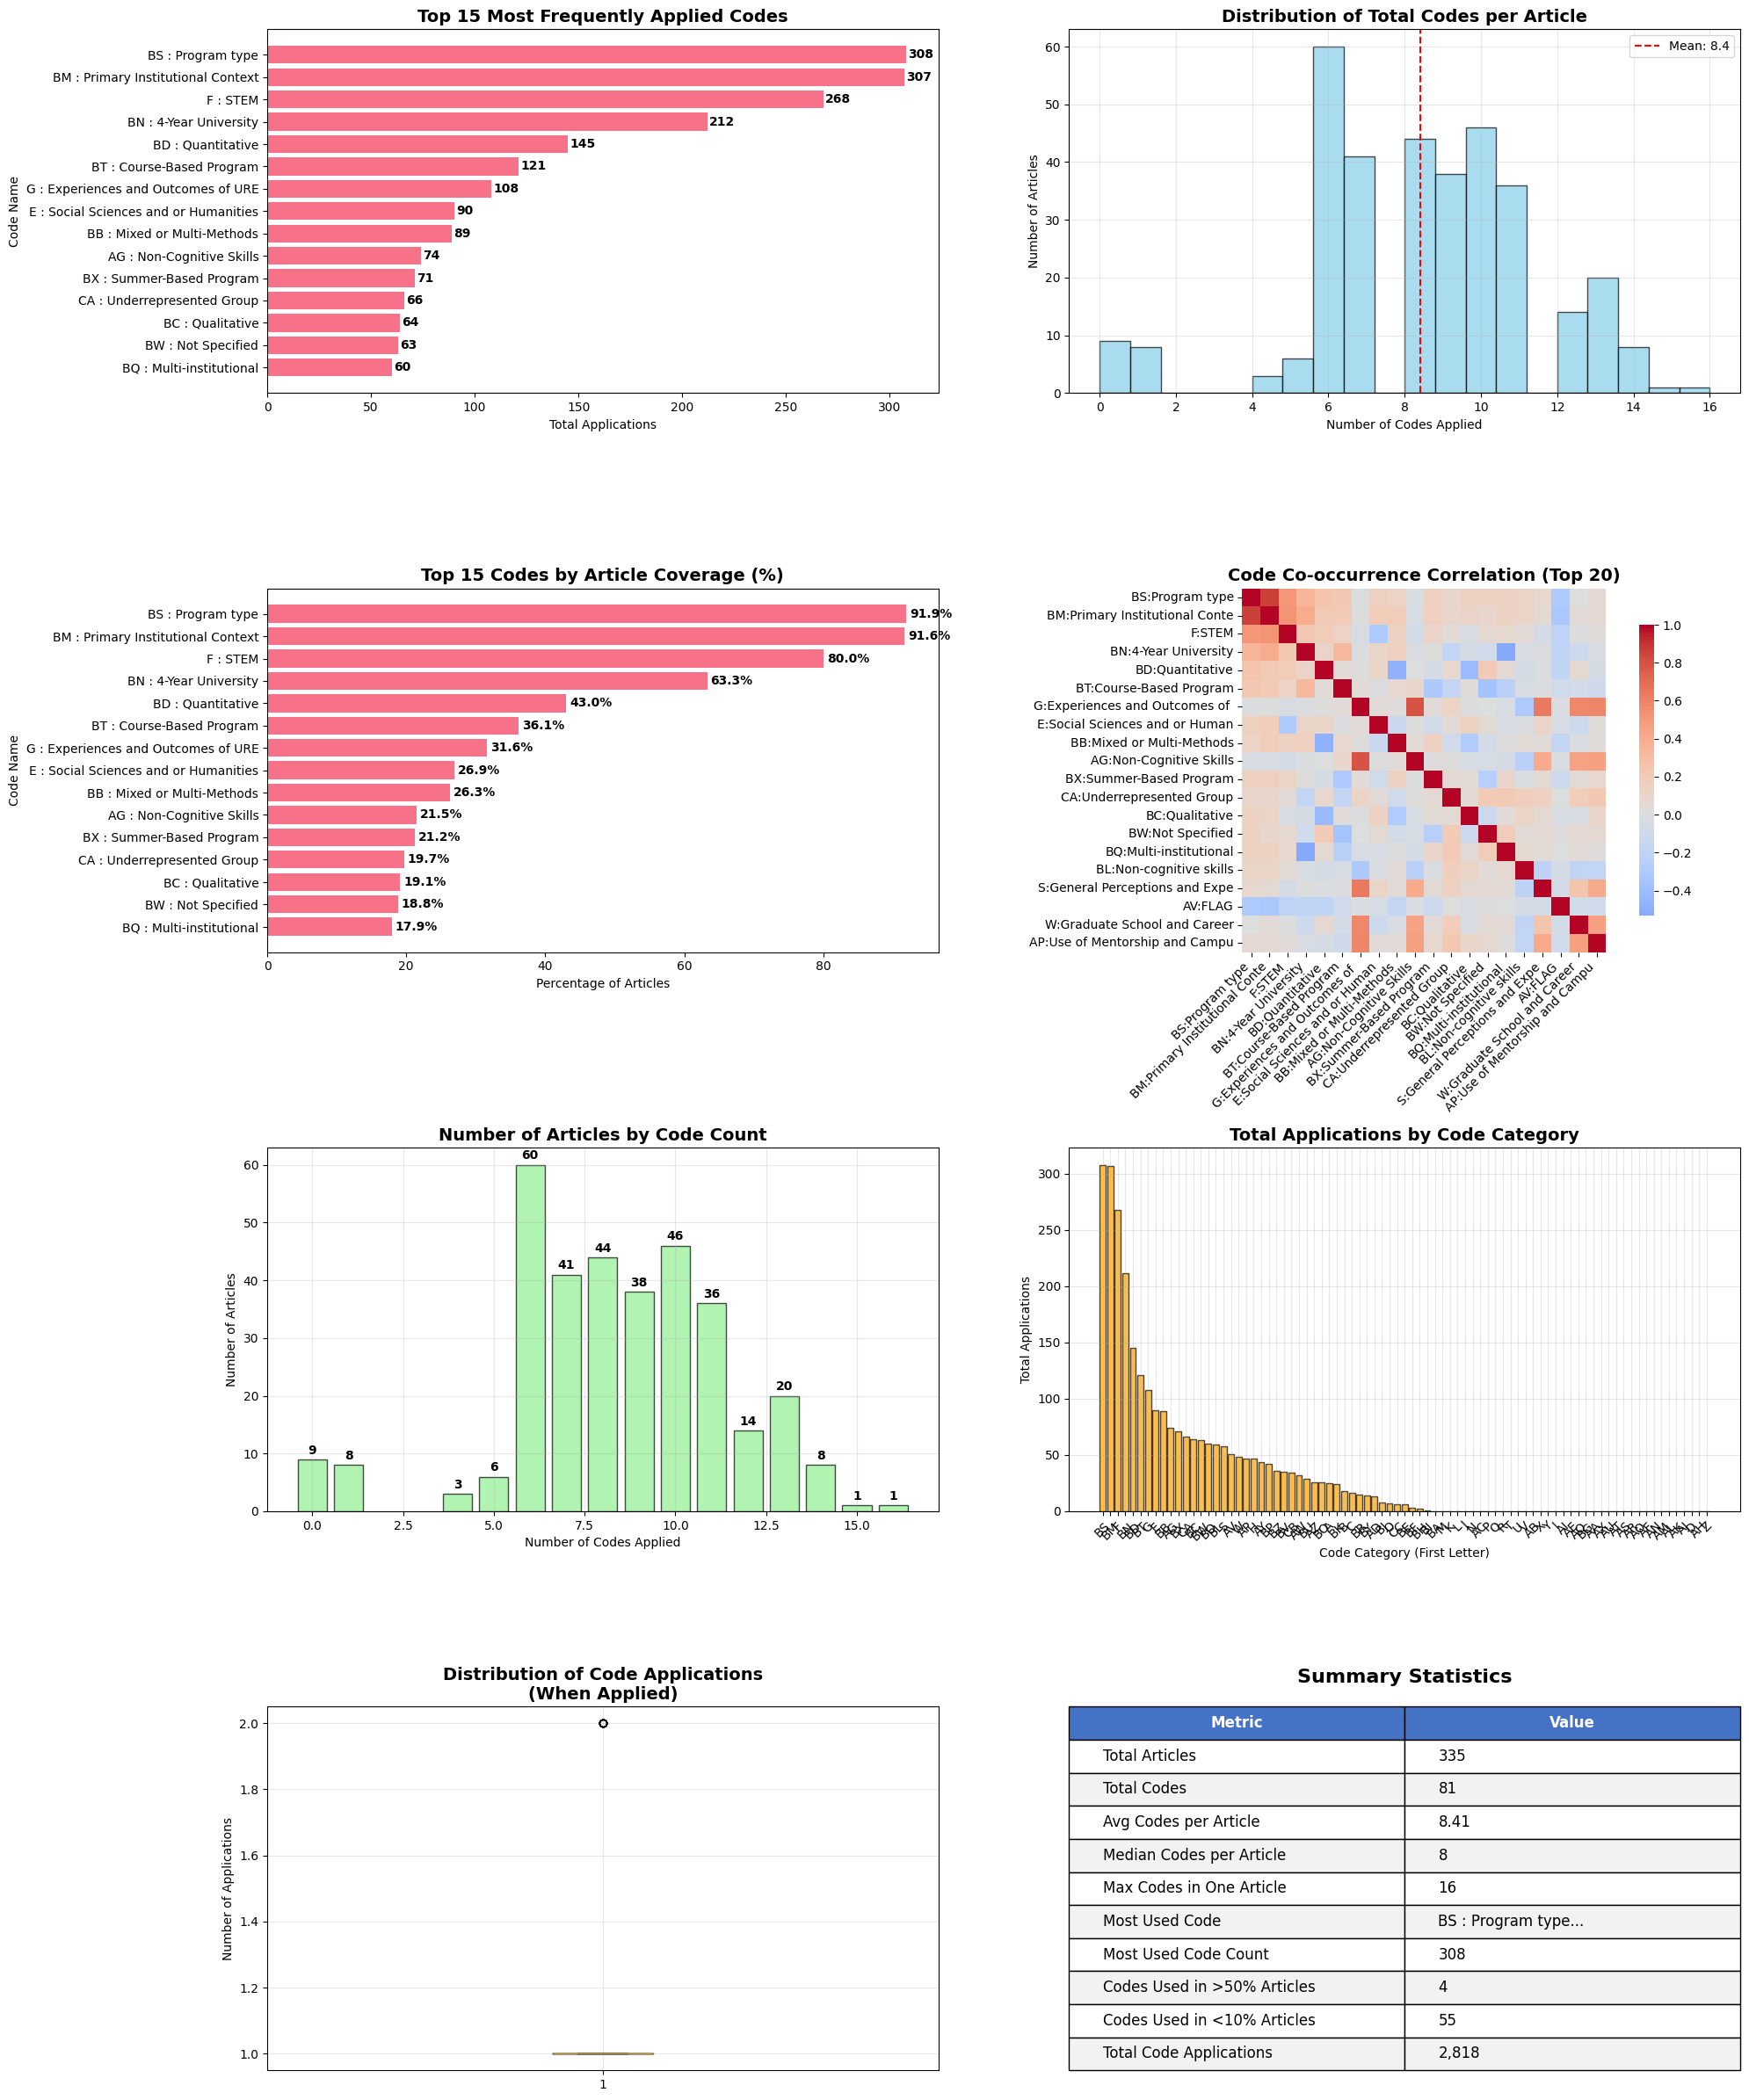

✓ Visualizations created and saved as 'coding_analysis_visualizations.png'


In [6]:
# Create visualizations for coding analysis
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def create_visualizations(articles_df, codes_df, df_original):
    """Create comprehensive visualizations for coding analysis"""
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette('husl')
    
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(20, 24))
    
    # 1. Top 15 Most Frequent Codes
    plt.subplot(4, 2, 1)
    top_codes = codes_df.head(15)
    bars = plt.barh(top_codes['Code_Name'], top_codes['Total_Applications'])
    plt.title('Top 15 Most Frequently Applied Codes', fontsize=14, fontweight='bold')
    plt.xlabel('Total Applications')
    plt.ylabel('Code Name')
    plt.gca().invert_yaxis()
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 1, bar.get_y() + bar.get_height()/2, 
                f'{int(width)}', ha='left', va='center', fontweight='bold')
    
    plt.tight_layout()
    
    # 2. Distribution of Codes per Article
    plt.subplot(4, 2, 2)
    plt.hist(articles_df['Total_Codes_Applied'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Distribution of Total Codes per Article', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Codes Applied')
    plt.ylabel('Number of Articles')
    plt.axvline(articles_df['Total_Codes_Applied'].mean(), color='red', linestyle='--', 
                label=f'Mean: {articles_df["Total_Codes_Applied"].mean():.1f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. Code Coverage (Percentage of Articles using each code)
    plt.subplot(4, 2, 3)
    top_coverage = codes_df.head(15)
    bars = plt.barh(top_coverage['Code_Name'], top_coverage['Percentage_of_Articles'])
    plt.title('Top 15 Codes by Article Coverage (%)', fontsize=14, fontweight='bold')
    plt.xlabel('Percentage of Articles')
    plt.ylabel('Code Name')
    plt.gca().invert_yaxis()
    
    # Add percentage labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{width:.1f}%', ha='left', va='center', fontweight='bold')
    
    # 4. Heatmap of Top Codes Correlation
    plt.subplot(4, 2, 4)
    # Get top 20 codes for correlation analysis
    top_20_codes = codes_df.head(20)['Code_Name'].tolist()
    code_cols = [f"Code_{code}" for code in top_20_codes if f"Code_{code}" in articles_df.columns]
    
    if len(code_cols) > 1:
        corr_matrix = articles_df[code_cols].corr()
        # Clean up column names for display
        clean_names = [col.replace('Code_', '').replace(' : ', ':')[:30] for col in corr_matrix.columns]
        corr_matrix.columns = clean_names
        corr_matrix.index = clean_names
        
        sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, 
                   square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
        plt.title('Code Co-occurrence Correlation (Top 20)', fontsize=14, fontweight='bold')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
    
    # 5. Articles by Number of Codes (Bar Chart)
    plt.subplot(4, 2, 5)
    code_counts = articles_df['Total_Codes_Applied'].value_counts().sort_index()
    plt.bar(code_counts.index, code_counts.values, alpha=0.7, color='lightgreen', edgecolor='black')
    plt.title('Number of Articles by Code Count', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Codes Applied')
    plt.ylabel('Number of Articles')
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (codes, count) in enumerate(zip(code_counts.index, code_counts.values)):
        if count > 0:
            plt.text(codes, count + 0.5, str(count), ha='center', va='bottom', fontweight='bold')
    
    # 6. Code Categories Analysis (if we can group codes)
    plt.subplot(4, 2, 6)
    # Group codes by first letter/category
    codes_df['Category'] = codes_df['Code_Name'].str.extract(r'^([A-Z]+)')
    category_stats = codes_df.groupby('Category').agg({
        'Total_Applications': 'sum',
        'Number_of_Articles': 'mean'
    }).sort_values('Total_Applications', ascending=False)
    
    plt.bar(category_stats.index, category_stats['Total_Applications'], 
           alpha=0.7, color='orange', edgecolor='black')
    plt.title('Total Applications by Code Category', fontsize=14, fontweight='bold')
    plt.xlabel('Code Category (First Letter)')
    plt.ylabel('Total Applications')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # 7. Box plot of code applications
    plt.subplot(4, 2, 7)
    # Get application counts for codes (non-zero only)
    code_applications = []
    for code in codes_df['Code_Name']:
        if f"Code_{code}" in articles_df.columns:
            apps = articles_df[f"Code_{code}"][articles_df[f"Code_{code}"] > 0].tolist()
            code_applications.extend(apps)
    
    if code_applications:
        plt.boxplot(code_applications)
        plt.title('Distribution of Code Applications\n(When Applied)', fontsize=14, fontweight='bold')
        plt.ylabel('Number of Applications')
        plt.grid(True, alpha=0.3)
    
    # 8. Summary Statistics Table
    plt.subplot(4, 2, 8)
    plt.axis('off')
    
    # Create summary statistics
    stats_data = [
        ['Total Articles', f"{len(articles_df):,}"],
        ['Total Codes', f"{len(codes_df):,}"],
        ['Avg Codes per Article', f"{articles_df['Total_Codes_Applied'].mean():.2f}"],
        ['Median Codes per Article', f"{articles_df['Total_Codes_Applied'].median():.0f}"],
        ['Max Codes in One Article', f"{articles_df['Total_Codes_Applied'].max():,}"],
        ['Most Used Code', f"{codes_df.iloc[0]['Code_Name'][:40]}..."],
        ['Most Used Code Count', f"{codes_df.iloc[0]['Total_Applications']:,}"],
        ['Codes Used in >50% Articles', f"{len(codes_df[codes_df['Percentage_of_Articles'] > 50]):,}"],
        ['Codes Used in <10% Articles', f"{len(codes_df[codes_df['Percentage_of_Articles'] < 10]):,}"],
        ['Total Code Applications', f"{codes_df['Total_Applications'].sum():,}"]
    ]
    
    # Create table
    table = plt.table(cellText=stats_data,
                     colLabels=['Metric', 'Value'],
                     cellLoc='left',
                     loc='center',
                     bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)
    
    # Style the table
    for i in range(len(stats_data) + 1):
        for j in range(2):
            cell = table[(i, j)]
            if i == 0:  # Header row
                cell.set_facecolor('#4472C4')
                cell.set_text_props(weight='bold', color='white')
            else:
                cell.set_facecolor('#F2F2F2' if i % 2 == 0 else 'white')
    
    plt.title('Summary Statistics', fontsize=16, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.savefig('coding_analysis_visualizations.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

# Run visualizations if data is available
if 'articles_spreadsheet' in locals() and 'codes_spreadsheet' in locals():
    print("Creating comprehensive visualizations...")
    fig = create_visualizations(articles_spreadsheet, codes_spreadsheet, df)
    print("✓ Visualizations created and saved as 'coding_analysis_visualizations.png'")
else:
    print("Please run the comprehensive analysis first to generate the visualization data!")

Creating detailed analysis visualizations...
1. ANALYZING CODE CO-OCCURRENCE PATTERNS


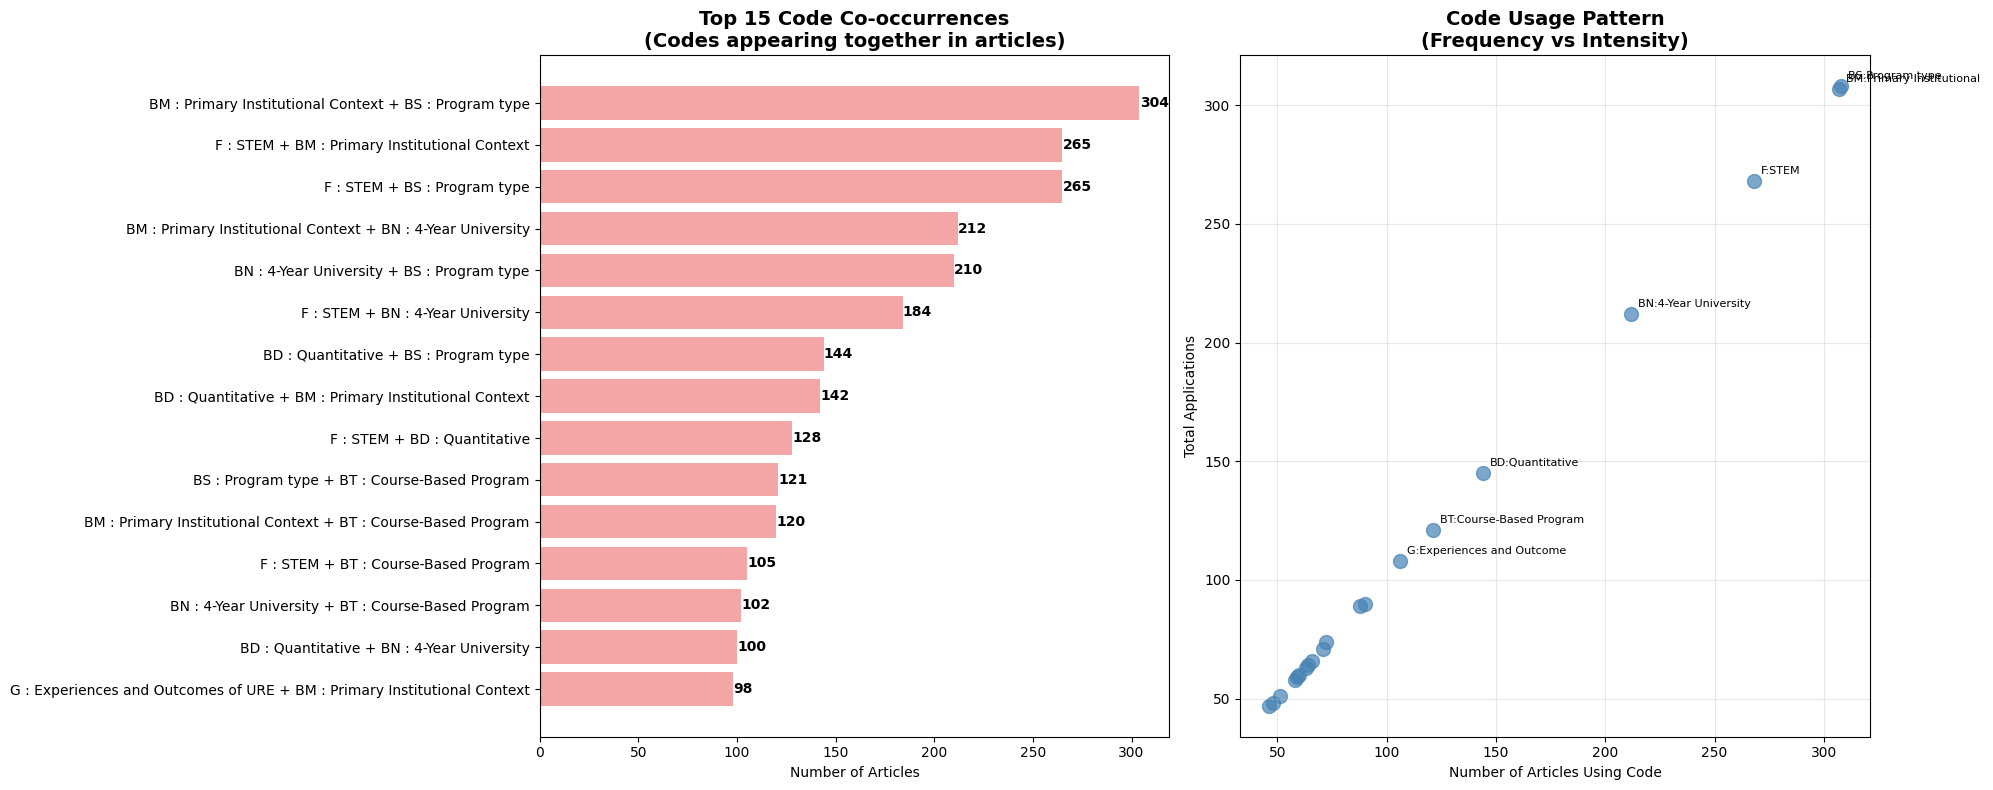


2. STATISTICAL INSIGHTS
📊 Code Frequency Distribution:
   • High frequency (>50% of articles): 4 codes
   • Medium frequency (10-50% of articles): 22 codes
   • Low frequency (<10% of articles): 55 codes

📈 Article Coding Patterns:
   • Articles with 1-5 codes: 26
   • Articles with 6-10 codes: 229
   • Articles with 11-15 codes: 79
   • Articles with 16+ codes: 1

🎯 Top 5 Most Applied Codes:
   71. BS : Program type
      → 308 applications across 308 articles (91.94%)
   65. BM : Primary Institutional Context
      → 307 applications across 307 articles (91.64%)
   6. F : STEM
      → 268 applications across 268 articles (80.0%)
   66. BN : 4-Year University
      → 212 applications across 212 articles (63.28%)
   56. BD : Quantitative
      → 145 applications across 144 articles (42.99%)

🔥 Universal Codes (used in >50% of articles):
   • BS : Program type (91.94%)
   • BM : Primary Institutional Context (91.64%)
   • F : STEM (80.0%)
   • BN : 4-Year University (63.28%)

✓ Detaile

In [8]:
# Additional specific visualizations and analysis
def create_detailed_analysis_plots(articles_df, codes_df):
    """Create detailed analysis plots for specific insights"""
    
    # 1. Code Co-occurrence Network Analysis
    print("1. ANALYZING CODE CO-OCCURRENCE PATTERNS")
    print("="*50)
    
    # Find frequently co-occurring codes
    code_cols = [col for col in articles_df.columns if col.startswith('Code_')]
    co_occurrence = {}
    
    for i, code1 in enumerate(code_cols):
        for code2 in code_cols[i+1:]:
            try:
                # Convert to numeric and count articles where both codes appear
                col1_numeric = pd.to_numeric(articles_df[code1], errors='coerce').fillna(0)
                col2_numeric = pd.to_numeric(articles_df[code2], errors='coerce').fillna(0)
                both_present = ((col1_numeric > 0) & (col2_numeric > 0)).sum()
                if both_present > 5:  # Only show pairs that co-occur in 5+ articles
                    code1_clean = code1.replace('Code_', '')
                    code2_clean = code2.replace('Code_', '')
                    co_occurrence[f"{code1_clean} + {code2_clean}"] = both_present
            except:
                continue
    
    # Plot top co-occurrences
    if co_occurrence:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        
        # Top co-occurrences
        top_cooccur = dict(sorted(co_occurrence.items(), key=lambda x: x[1], reverse=True)[:15])
        
        ax1.barh(list(top_cooccur.keys()), list(top_cooccur.values()), alpha=0.7, color='lightcoral')
        ax1.set_title('Top 15 Code Co-occurrences\n(Codes appearing together in articles)', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Number of Articles')
        ax1.invert_yaxis()
        
        # Add value labels
        for i, (pair, count) in enumerate(top_cooccur.items()):
            ax1.text(count + 0.1, i, str(count), va='center', fontweight='bold')
    
    # 2. Code Efficiency Analysis (Applications per Article)
    top_20_codes = codes_df.head(20)
    efficiency = top_20_codes['Total_Applications'] / top_20_codes['Number_of_Articles']
    
    ax2.scatter(top_20_codes['Number_of_Articles'], top_20_codes['Total_Applications'], 
               s=100, alpha=0.7, color='steelblue')
    ax2.set_xlabel('Number of Articles Using Code')
    ax2.set_ylabel('Total Applications')
    ax2.set_title('Code Usage Pattern\n(Frequency vs Intensity)', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Add labels for outliers
    for idx, row in top_20_codes.iterrows():
        ratio = row['Total_Applications'] / row['Number_of_Articles']
        if ratio > 2 or row['Number_of_Articles'] > 100:  # High intensity or high frequency
            code_name = row['Code_Name'].replace(' : ', ':')[:25]
            ax2.annotate(code_name, 
                        (row['Number_of_Articles'], row['Total_Applications']),
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    plt.tight_layout()
    plt.savefig('detailed_coding_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. Statistical Summary
    print("\n2. STATISTICAL INSIGHTS")
    print("="*50)
    
    # Code distribution analysis
    high_freq_codes = codes_df[codes_df['Percentage_of_Articles'] > 50]
    medium_freq_codes = codes_df[(codes_df['Percentage_of_Articles'] >= 10) & 
                                (codes_df['Percentage_of_Articles'] <= 50)]
    low_freq_codes = codes_df[codes_df['Percentage_of_Articles'] < 10]
    
    print(f"📊 Code Frequency Distribution:")
    print(f"   • High frequency (>50% of articles): {len(high_freq_codes)} codes")
    print(f"   • Medium frequency (10-50% of articles): {len(medium_freq_codes)} codes")
    print(f"   • Low frequency (<10% of articles): {len(low_freq_codes)} codes")
    
    print(f"\n📈 Article Coding Patterns:")
    print(f"   • Articles with 1-5 codes: {len(articles_df[articles_df['Total_Codes_Applied'] <= 5])}")
    print(f"   • Articles with 6-10 codes: {len(articles_df[(articles_df['Total_Codes_Applied'] > 5) & (articles_df['Total_Codes_Applied'] <= 10)])}")
    print(f"   • Articles with 11-15 codes: {len(articles_df[(articles_df['Total_Codes_Applied'] > 10) & (articles_df['Total_Codes_Applied'] <= 15)])}")
    print(f"   • Articles with 16+ codes: {len(articles_df[articles_df['Total_Codes_Applied'] > 15])}")
    
    print(f"\n🎯 Top 5 Most Applied Codes:")
    for idx, row in codes_df.head(5).iterrows():
        print(f"   {idx+1}. {row['Code_Name'][:50]}")
        print(f"      → {row['Total_Applications']} applications across {row['Number_of_Articles']} articles ({row['Percentage_of_Articles']}%)")
    
    if len(high_freq_codes) > 0:
        print(f"\n🔥 Universal Codes (used in >50% of articles):")
        for idx, row in high_freq_codes.iterrows():
            print(f"   • {row['Code_Name'][:50]} ({row['Percentage_of_Articles']}%)")
    
    return co_occurrence

# Run detailed analysis
if 'articles_spreadsheet' in locals() and 'codes_spreadsheet' in locals():
    print("Creating detailed analysis visualizations...")
    co_occur_data = create_detailed_analysis_plots(articles_spreadsheet, codes_spreadsheet)
    print("\n✓ Detailed analysis complete!")
    print("✓ Saved 'detailed_coding_analysis.png'")
else:
    print("Please run the comprehensive analysis first!")

In [9]:
# Summary of all created files
import os

print("📁 ANALYSIS COMPLETE - FILES CREATED:")
print("="*60)

# Check which files exist
files_to_check = [
    ('comprehensive_coding_analysis.xlsx', 'Main Excel file with 4 sheets'),
    ('articles_with_codes_and_metadata.csv', 'Articles analysis CSV'),
    ('codes_with_article_details.csv', 'Codes analysis CSV'),
    ('coding_matrix_crosstab.csv', 'Cross-tabulation matrix CSV'),
    ('coding_analysis_visualizations.png', 'Main visualization dashboard'),
    ('detailed_coding_analysis.png', 'Detailed co-occurrence analysis'),
    ('article_summary.csv', 'Basic article summary'),
    ('code_summary.csv', 'Basic code summary')
]

existing_files = []
for filename, description in files_to_check:
    if os.path.exists(filename):
        file_size = os.path.getsize(filename)
        if file_size > 1024*1024:  # > 1MB
            size_str = f"{file_size/(1024*1024):.1f} MB"
        elif file_size > 1024:  # > 1KB
            size_str = f"{file_size/1024:.1f} KB"
        else:
            size_str = f"{file_size} bytes"
        
        existing_files.append((filename, description, size_str))
        print(f"✅ {filename} ({size_str})")
        print(f"   📝 {description}")
    else:
        print(f"❌ {filename} - Not found")

print(f"\n📊 SUMMARY:")
print(f"   • {len(existing_files)} files created successfully")
print(f"   • Total articles analyzed: {len(articles_spreadsheet) if 'articles_spreadsheet' in locals() else 'N/A'}")
print(f"   • Total codes analyzed: {len(codes_spreadsheet) if 'codes_spreadsheet' in locals() else 'N/A'}")
print(f"   • Analysis includes: coding patterns, co-occurrence, statistical summaries")
print(f"   • Visualizations: comprehensive dashboard + detailed analysis plots")

print(f"\n🎯 NEXT STEPS:")
print(f"   1. Open comprehensive_coding_analysis.xlsx for detailed analysis")
print(f"   2. View PNG files for visual insights")
print(f"   3. Use CSV files for further statistical analysis")
print(f"   4. Consider adding external metadata if available")

📁 ANALYSIS COMPLETE - FILES CREATED:
✅ comprehensive_coding_analysis.xlsx (261.8 KB)
   📝 Main Excel file with 4 sheets
✅ articles_with_codes_and_metadata.csv (286.4 KB)
   📝 Articles analysis CSV
✅ codes_with_article_details.csv (339.4 KB)
   📝 Codes analysis CSV
✅ coding_matrix_crosstab.csv (92.4 KB)
   📝 Cross-tabulation matrix CSV
✅ coding_analysis_visualizations.png (1.6 MB)
   📝 Main visualization dashboard
✅ detailed_coding_analysis.png (479.3 KB)
   📝 Detailed co-occurrence analysis
✅ article_summary.csv (110.3 KB)
   📝 Basic article summary
✅ code_summary.csv (2.5 KB)
   📝 Basic code summary

📊 SUMMARY:
   • 8 files created successfully
   • Total articles analyzed: 335
   • Total codes analyzed: 81
   • Analysis includes: coding patterns, co-occurrence, statistical summaries
   • Visualizations: comprehensive dashboard + detailed analysis plots

🎯 NEXT STEPS:
   1. Open comprehensive_coding_analysis.xlsx for detailed analysis
   2. View PNG files for visual insights
   3. Use